# Exploratory Data Analysis - Medical Insurance Costs (Deep Dive & Enhanced)

In this notebook, we perform a comprehensive analysis of the Medical Insurance dataset to understand the **causal factors** driving insurance premiums.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load Data
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../src')))
from data_loader import load_data, clean_data

df = load_data('../insurance.csv')
df = clean_data(df)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 1. Univariate Analysis
Understanding the distribution of key variables individually.

### 1.1 Target Variable: Charges

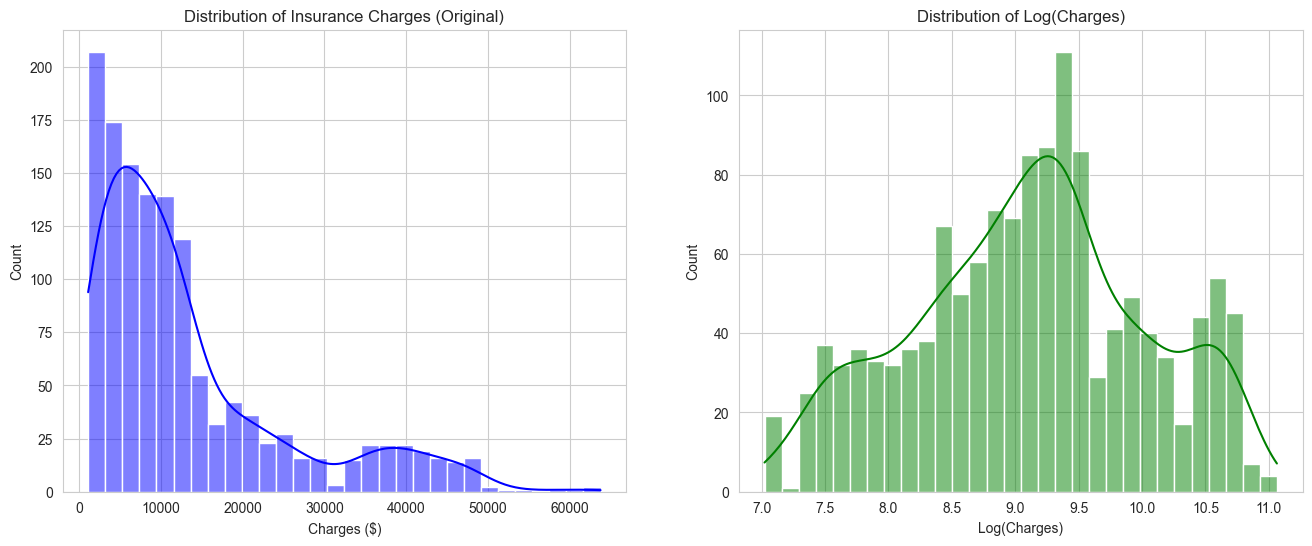

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Original Distribution
sns.histplot(df['charges'], kde=True, bins=30, ax=ax[0], color='blue')
ax[0].set_title('Distribution of Insurance Charges (Original)')
ax[0].set_xlabel('Charges ($)')

# Log Transformed
sns.histplot(np.log1p(df['charges']), kde=True, bins=30, ax=ax[1], color='green')
ax[1].set_title('Distribution of Log(Charges)')
ax[1].set_xlabel('Log(Charges)')

plt.show()

**Deep Analysis:**
*   **Original:** The distribution is heavily right-skewed. The majority of beneficiaries pay <$15k, but a significant long tail extends to $60k+. This suggests "high-risk" groups (smokers, elderly, obese) drive the tail.
*   **Log-Transformed:** Applying `log(1+x)` normalizes the data significantly, making it much more Gaussian. This confirms that for linear models (Linear Regression, Ridge), using the log-target will yield far better residual distributions and predictions.

### 1.2 Key Predictors: Age and BMI

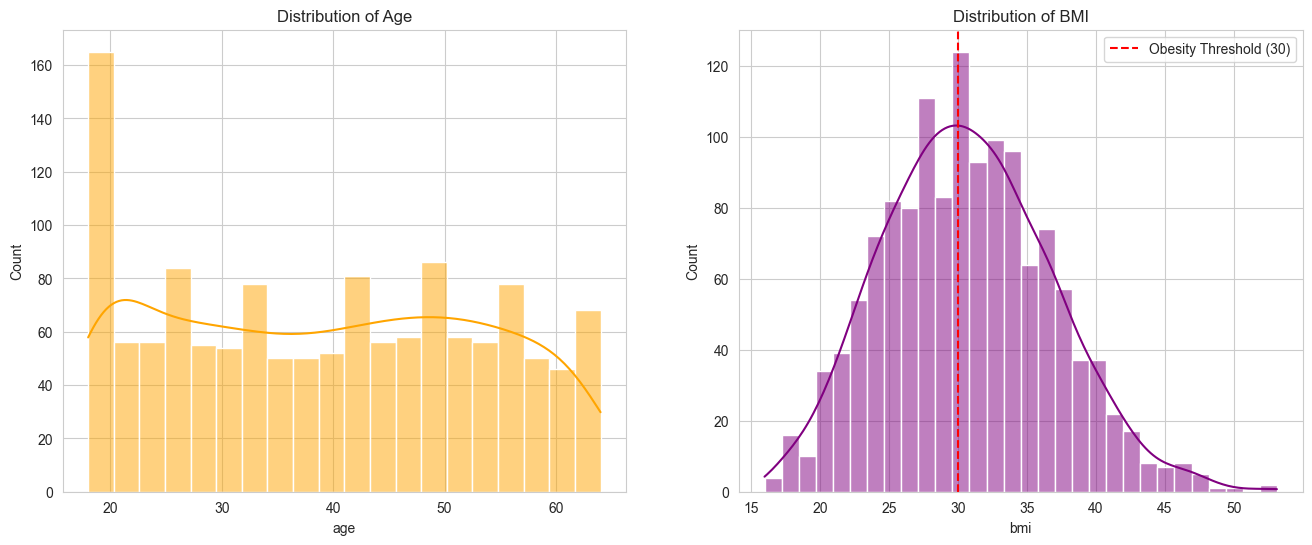

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['age'], kde=True, bins=20, ax=ax[0], color='orange')
ax[0].set_title('Distribution of Age')

sns.histplot(df['bmi'], kde=True, bins=30, ax=ax[1], color='purple')
ax[1].set_title('Distribution of BMI')
ax[1].axvline(30, color='red', linestyle='--', label='Obesity Threshold (30)')
ax[1].legend()

plt.show()

**Deep Analysis:**
*   **Age:** The dataset is fairly uniform across ages 20-60, with a spike at age 18-19. This creates a balanced dataset for age-based prediction.
*   **BMI:** Follows a near-perfect Normal Distribution centered around ~30. 
*   **Concern:** The mean BMI is ~30.6, which classifies the *average* person in this dataset as Obese (BMI > 30). This is a critical health insight.

# 2. Bivariate Analysis

### 2.1 The Smoker Effect
Smoking status is expected to be the strongest predictor.

/var/folders/d5/q872yxxd2z7c5l_6c2n_wpy40000gn/T/ipykernel_82439/3248552446.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='smoker', y='charges', data=df, palette='Set2', inner='quartile')


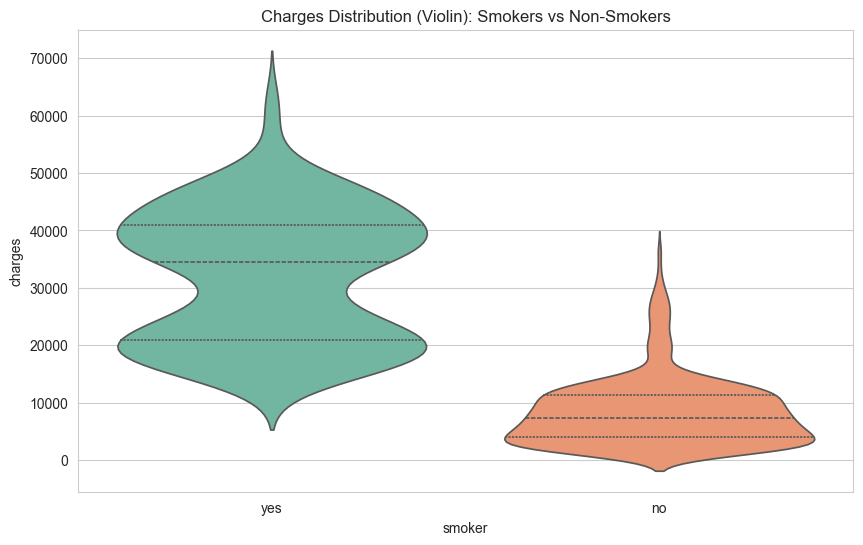

In [5]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='smoker', y='charges', data=df, palette='Set2', inner='quartile')
plt.title('Charges Distribution (Violin): Smokers vs Non-Smokers')
plt.show()

**Deep Analysis:**
*   **Shape Difference:** Notice the *Violin Plot* shape.
    *   *Non-Smokers:* Bulky at the bottom (low cost) with a thin tail upwards.
    *   *Smokers:* **Bimodal distribution**. There isn't just one "Smoker Price". There are two humps: one around $20k and another around $40k. This indicates a *secondary factor* separates cheap smokers from expensive smokers. (Spoiler: It's BMI).

### 2.2 Region and Gender Analysis
Do location or gender impact costs significantly?

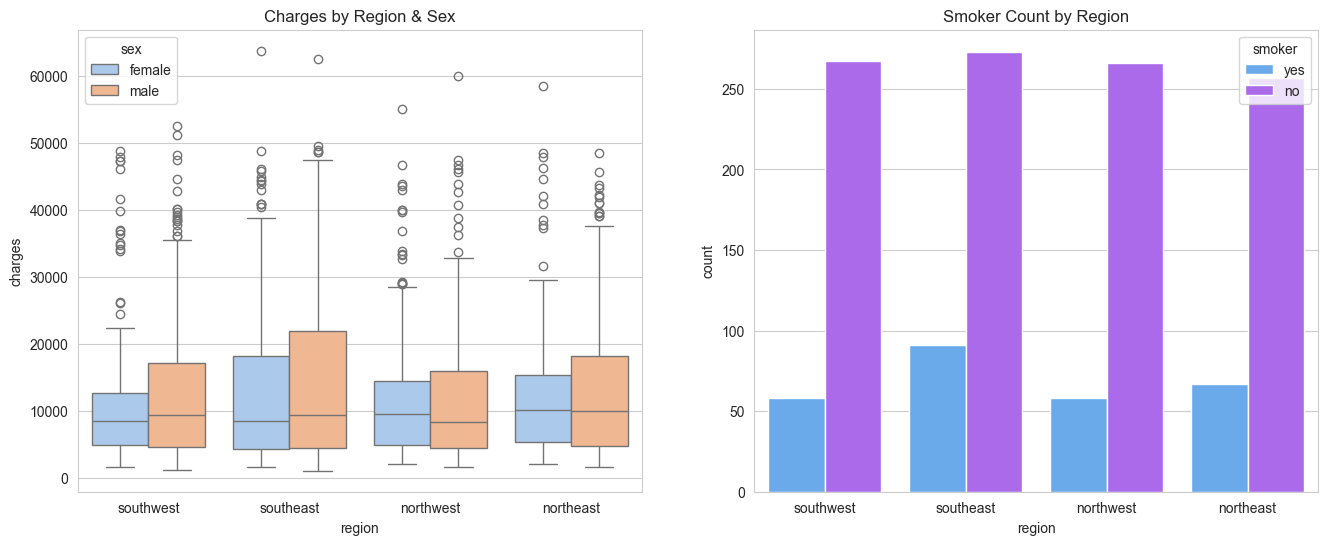

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='region', y='charges', hue='sex', data=df, ax=ax[0], palette='pastel')
ax[0].set_title('Charges by Region & Sex')

sns.countplot(x='region', hue='smoker', data=df, ax=ax[1], palette='cool')
ax[1].set_title('Smoker Count by Region')

plt.show()

**Deep Analysis:**
*   **Region/Sex:** Costs are relatively consistent across regions and genders. No massive disparity exists purely based on living in the 'northeast' vs 'southwest'.
*   **Smoker prevalence:** The `Southeast` region has the highest number of smokers (see the second chart). This likely explains why the Southeast often has slightly higher average changes in aggregate stats—it's not the region itself, it's the lifestyle of the population there.

# 3. Multivariate Analysis (Interactions)

### 3.1 The "Obesity-Smoking" Multiplier
Does BMI matter equally for everyone?

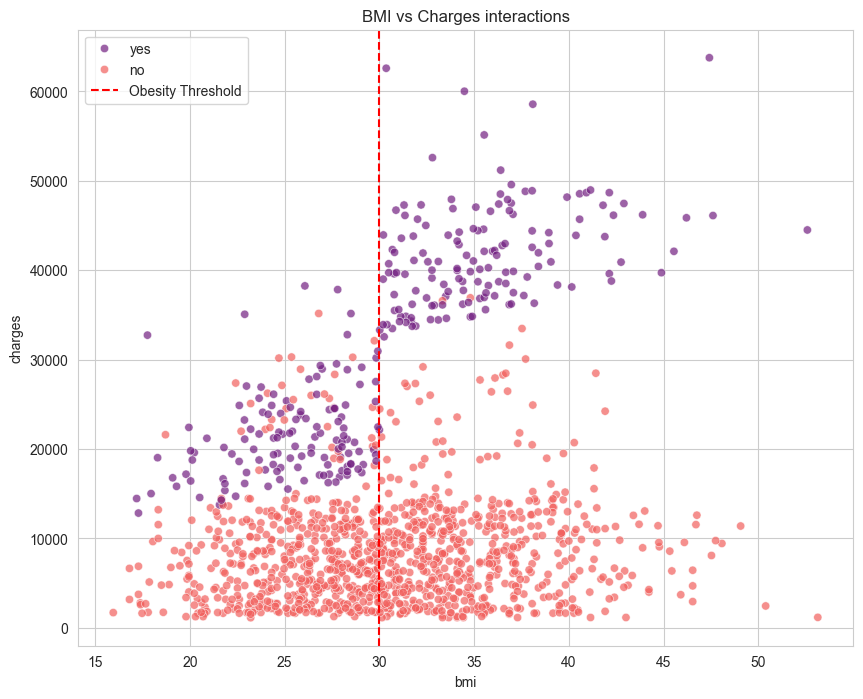

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.7, palette='magma')
plt.axvline(30, color='red', linestyle='--', label='Obesity Threshold')
plt.title('BMI vs Charges interactions')
plt.legend()
plt.show()

**Deep Analysis:**
*   **The Gradient Shift:** 
    *   *Non-Smokers (Purple):* Flat slope. BMI increases have minimal cost impact.
    *   *Smokers (Orange):* Steep slope. there is a distinct "kink" at **BMI 30**.
*   **The Danger Zone:** Smokers with BMI > 30 (Obese) instantly jump to the highest cost bracket ($35k - $60k). This interaction term (`smoker * bmi_obese`) is likely the most powerful feature for our model.

### 3.2 Global Pairplot
Visualizing all pair-wise relationships to spot patterns we missed.

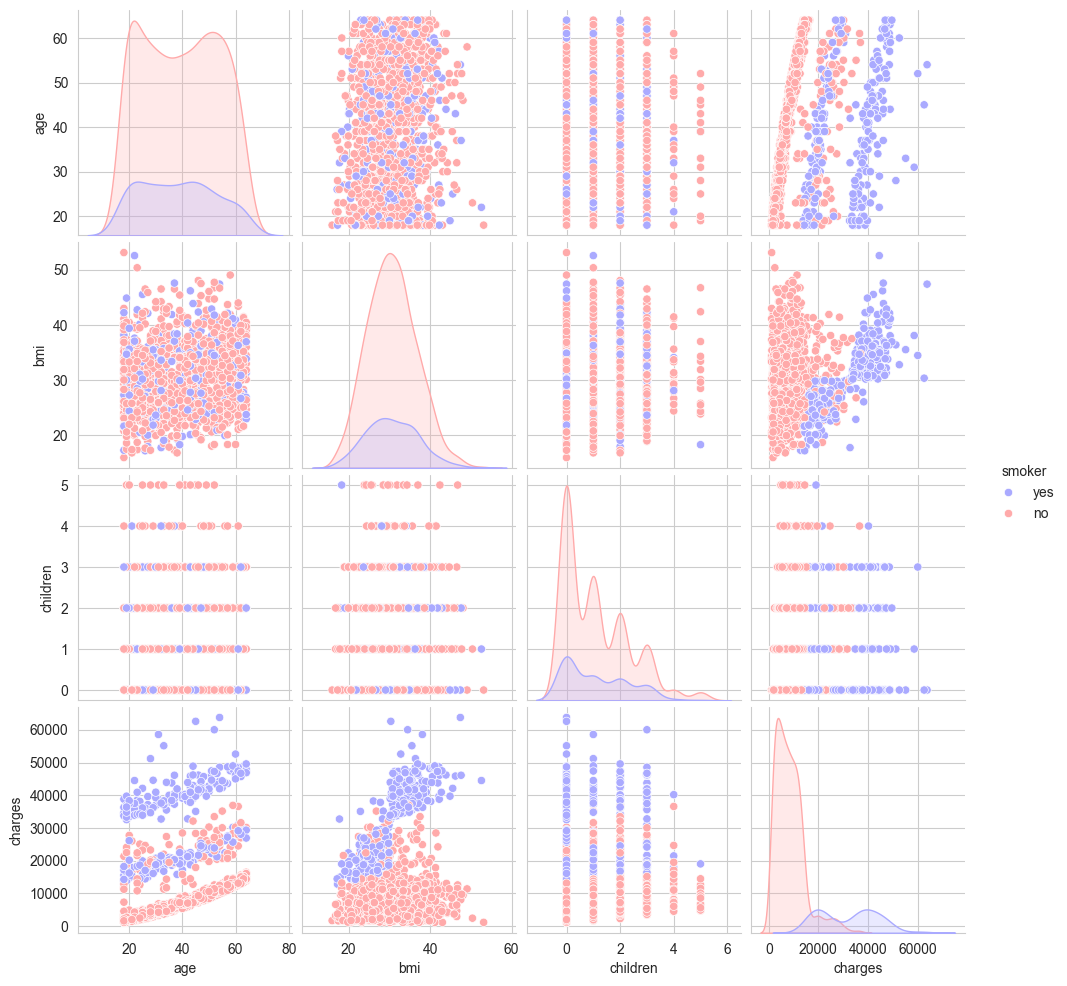

In [8]:
sns.pairplot(df, hue='smoker', palette='bwr')
plt.show()

**Deep Analysis:**
*   **Separation:** The `charges` row (bottom row) clearly shows that `smoker=yes` (Red) is always separated from `smoker=no` (Blue) into a higher cluster.
*   **Age:** You can see the linear bands in the `age` vs `charges` plot clearly.
*   **BMI:** The `bmi` vs `charges` plot confirms the "fan" shape: broad spread for smokers, narrow flat spread for non-smokers.

## 4. Summary

1.  **Smoking is the dominant factor**, appearing to increase costs by ~4x.
2.  **Obesity (BMI > 30) acts as a multiplier** specifically for smokers. It does *not* drastically increase costs for non-smokers.
3.  **Age is a linear adder**, increasing costs steadily over time.
4.  **Region and Gender** have minimal direct impact, serving mostly as demographic controls.